In [1]:
# Cloning data dari github
!git clone https://github.com/adizaen/Car_Damage_Detection

Cloning into 'Car_Damage_Detection'...
remote: Enumerating objects: 2453, done.
remote: Total 2453 (delta 0), reused 0 (delta 0), pack-reused 2453
Receiving objects: 100% (2453/2453), 89.79 MiB | 31.38 MiB/s, done.
Resolving deltas: 100% (249/249), done.
Checking out files: 100% (4178/4178), done.


In [2]:
# Masuk ke folder models
%cd Car_Damage_Detection/models

/content/Car_Damage_Detection/models


In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [15]:
# Install library yang diperlukan. Sudah dilist di file requirements.txt
!pip install -r ../requirements.txt

     |████████████████████████████████| 112kB 4.2MB/s 
     |████████████████████████████████| 153kB 8.9MB/s 
     |████████████████████████████████| 163kB 11.5MB/s 
     |████████████████████████████████| 2.0MB 11.8MB/s 
     |████████████████████████████████| 3.0MB 29.2MB/s 
     |████████████████████████████████| 122kB 40.4MB/s 
     |████████████████████████████████| 788kB 37.6MB/s 
     |████████████████████████████████| 122kB 56.2MB/s 
     |████████████████████████████████| 1.1MB 54.4MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
     |████████████████████████████████| 112kB 50.0MB/s 
     |████████████████████████████████| 92kB 9.0MB/s 
     |████████████████████████████████| 92kB 7.4MB/s 
     |████████████████████████████████| 5.5MB 42.7MB/s 
     |████████████████████████████████| 92kB 9.5MB/s 
     |████████████████████████████████| 12.4MB 24.1MB/s 
     |████████████████████████████████| 174kB 47.6MB/s 
     |████████████████████████████████| 9.7MB 37.7MB/s 
 

In [33]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from google.colab import files

# Ini diperlukan karena notebook disimpan di folder object_detection
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')

In [34]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [35]:
# Model yang akan di download
MODEL_NAME = 'inference_graph'

# Jalur ke frozen detection graph. Ini adalah model aktual yang digunakan untuk deteksi objek.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# Daftar string label untuk deteksi setiap object (damage)
PATH_TO_LABELS = os.path.join(MODEL_NAME, 'labelmap.pbtxt')

In [36]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [37]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [38]:
category_index

{1: {'id': 1, 'name': 'damage'}}

In [39]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [40]:
# untuk upload gambar yang akan dideteksi kerusakan body nya
%cd test_images
uploaded = files.upload()
for fn in uploaded.keys():
  filename=fn
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, filename) ]

# menentukan ukuran gambar
IMAGE_SIZE = (17, 13)
%cd ..

/content/Car_Damage_Detection/models/test_images


Saving 0020.JPEG to 0020.JPEG
/content/Car_Damage_Detection/models


In [41]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Mendapat input dan output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # Proses untuk gambar tunggal
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        
        # Reframe diperlukan untuk menerjemahkan topeng dari koordinat kotak ke koordinat gambar dan menyesuaikan ukuran gambar.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        
        # Ikuti konvensi dengan menambahkan kembali dimensi batch
        tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
        image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

        # Jalankan inference
        output_dict = sess.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})

        # semua keluaran adalah array numpy float32, jadi konversikan jenis yang sesuai
        output_dict['num_detections'] = int(output_dict['num_detections'][0])
        output_dict['detection_classes'] = output_dict[
            'detection_classes'][0].astype(np.uint8)
        output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
        output_dict['detection_scores'] = output_dict['detection_scores'][0]

      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

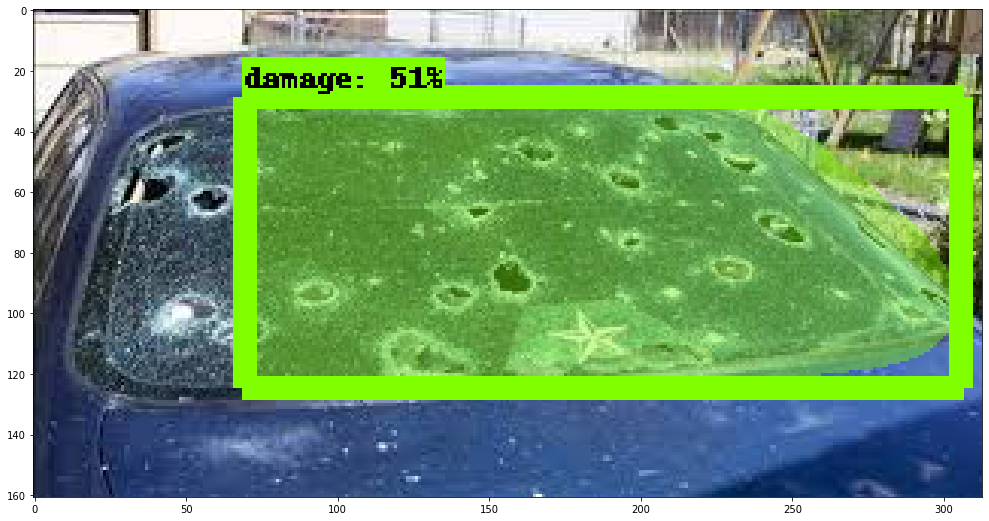

In [42]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # Hasil gambar akan tampil dengan bingkai dan tingkat kerusakan dalam satuan persen
  image_np = load_image_into_numpy_array(image)
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Deteksi yang nyata/aktual
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualisasi hasil deteksi
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)